In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch

from sklearn import preprocessing

# Import Robot Dynamics
from dynamics.robot_selector import robot_selector
from dynamics.data_gen_robot import data_gen_robot_multi

from utils import sprandsym

from core.reservoir_comp import train_reservior, validate_reservoir

import scipy.io
import scipy.sparse
import random

## Robot Generation

In [2]:
# robot_selcetion
robot_type = "3R"
modality = "3D"
robot_name = robot_type + "_" + modality

In [3]:
# robot pars
robot_pars = {}
robot_pars['m'] = 0.1
robot_pars['I'] = np.eye(3)
robot_pars['l'] = 0.33

# robot parameters changed
robot_pars_changed = {}
robot_pars_changed ['m'] = 0.1
robot_pars_changed ['I'] = 1.5*np.eye(3)
robot_pars_changed ['l'] = 0.33

In [4]:
# get robots
robot = robot_selector(robot_name,robot_pars)
robot_changed = robot_selector(robot_name,robot_pars_changed)

In [5]:
print(robot)
print(robot_changed)

DHRobot: 3R_3D, 3 joints (RRR), dynamics, standard DH parameters
┌────┬────┬──────┬───────┐
│θⱼ  │ dⱼ │  aⱼ  │  ⍺ⱼ   │
├────┼────┼──────┼───────┤
│ q1 │  0 │ 0.33 │  0.0° │
│ q2 │  0 │ 0.33 │ 90.0° │
│ q3 │  0 │ 0.33 │  0.0° │
└────┴────┴──────┴───────┘

┌─┬──┐
└─┴──┘

DHRobot: 3R_3D, 3 joints (RRR), dynamics, standard DH parameters
┌────┬────┬──────┬───────┐
│θⱼ  │ dⱼ │  aⱼ  │  ⍺ⱼ   │
├────┼────┼──────┼───────┤
│ q1 │  0 │ 0.33 │  0.0° │
│ q2 │  0 │ 0.33 │ 90.0° │
│ q3 │  0 │ 0.33 │  0.0° │
└────┴────┴──────┴───────┘

┌─┬──┐
└─┴──┘



# Data Generation

In [6]:
# Base Parameters
dt = 0.02 #time step
num_snaps = 1000 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 100 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories

In [7]:
controller = 'controller' # controller used or not for data generation
num_joints = robot.random_q().shape[0]
num_states = 2*robot.random_q().shape[0]
num_inputs = num_joints

if robot.name.__contains__("2D"):
    num_states_cart = 2
else:
    num_states_cart = 3
T = np.linspace(0,num_snaps*dt,num_snaps)

In [8]:
X_end_unchanged,X_unchanged, X_end_changed, X_changed, U = data_gen_robot_multi(dt,num_traj,num_snaps, robot, robot_changed, controller)
print(X_changed.shape, U.shape)

(125, 1000, 6) (125, 999, 3)


In [9]:
# Check for nan values
print(sum(sum(sum(np.isnan(X_changed)))))
print(sum(sum(sum(np.isnan(X_unchanged)))))

0
0


In [10]:
# change in dynamics
# l2 change
l2_diff = np.linalg.norm(X_changed-X_unchanged)/((X_changed.size)**(1/2))
print('l2_diff = ', l2_diff)

# fractional change
change_in_dym = np.linalg.norm((X_changed-X_unchanged)/X_changed)/X_changed.size
print('fraction of change in dynamics = ', change_in_dym)

l2_diff =  1.240201888795051
fraction of change in dynamics =  0.18562129830117138


Text(0.5, 0.98, 'Original Dynamics')

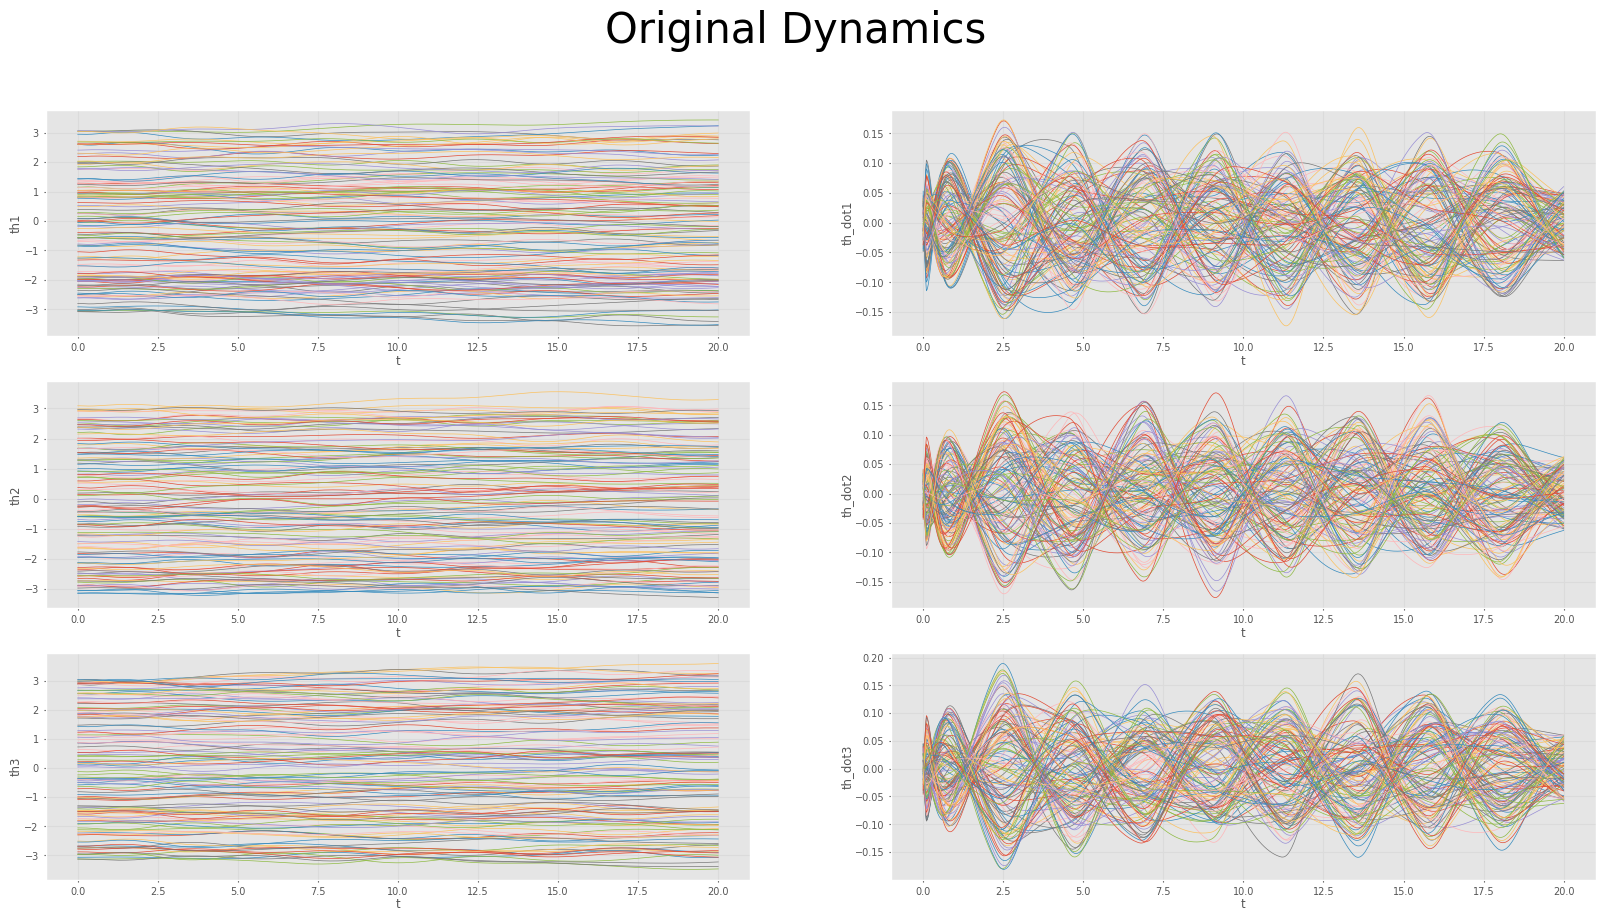

In [11]:
# Overall data
plt.figure(figsize = (20,10))

for j in range(num_traj):
    for i in range(int(num_joints)):
        plt.subplot(num_joints,2,2*i+1)
        plt.xlabel("t")
        plt.ylabel("th"+str(i+1))
        plt.plot(T,X_unchanged[j,:,i])
        plt.subplot(num_joints,2,2*i+2)
        plt.xlabel("t")
        plt.ylabel("th_dot"+str(i+1))
        plt.plot(T,X_unchanged[j,:,num_joints+i])
plt.suptitle("Original Dynamics", fontsize=30)


Text(0.5, 0.98, 'Changed Dynamics')

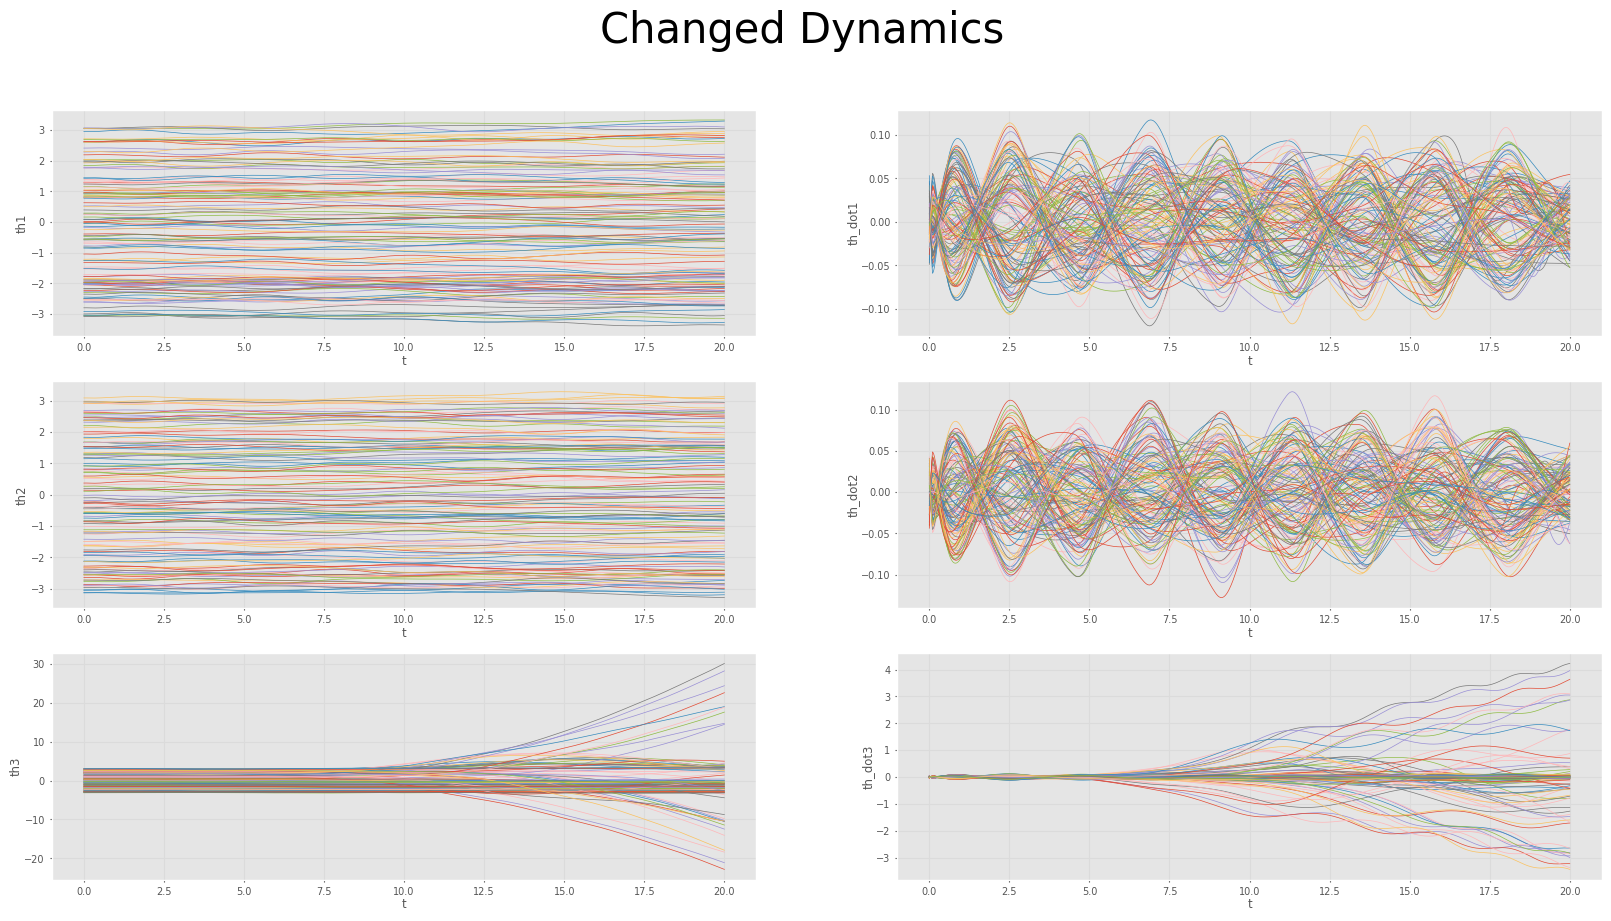

In [12]:
# Overall data
plt.figure(figsize = (20,10))

for j in range(num_traj):
    for i in range(int(num_joints)):
        plt.subplot(num_joints,2,2*i+1)
        plt.xlabel("t")
        plt.ylabel("th"+str(i+1))
        plt.plot(T,X_changed[j,:,i])
        plt.subplot(num_joints,2,2*i+2)
        plt.xlabel("t")
        plt.ylabel("th_dot"+str(i+1))
        plt.plot(T,X_changed[j,:,num_joints+i])
plt.suptitle("Changed Dynamics", fontsize=30)

Text(0.5, 0.98, 'Control Inputs')

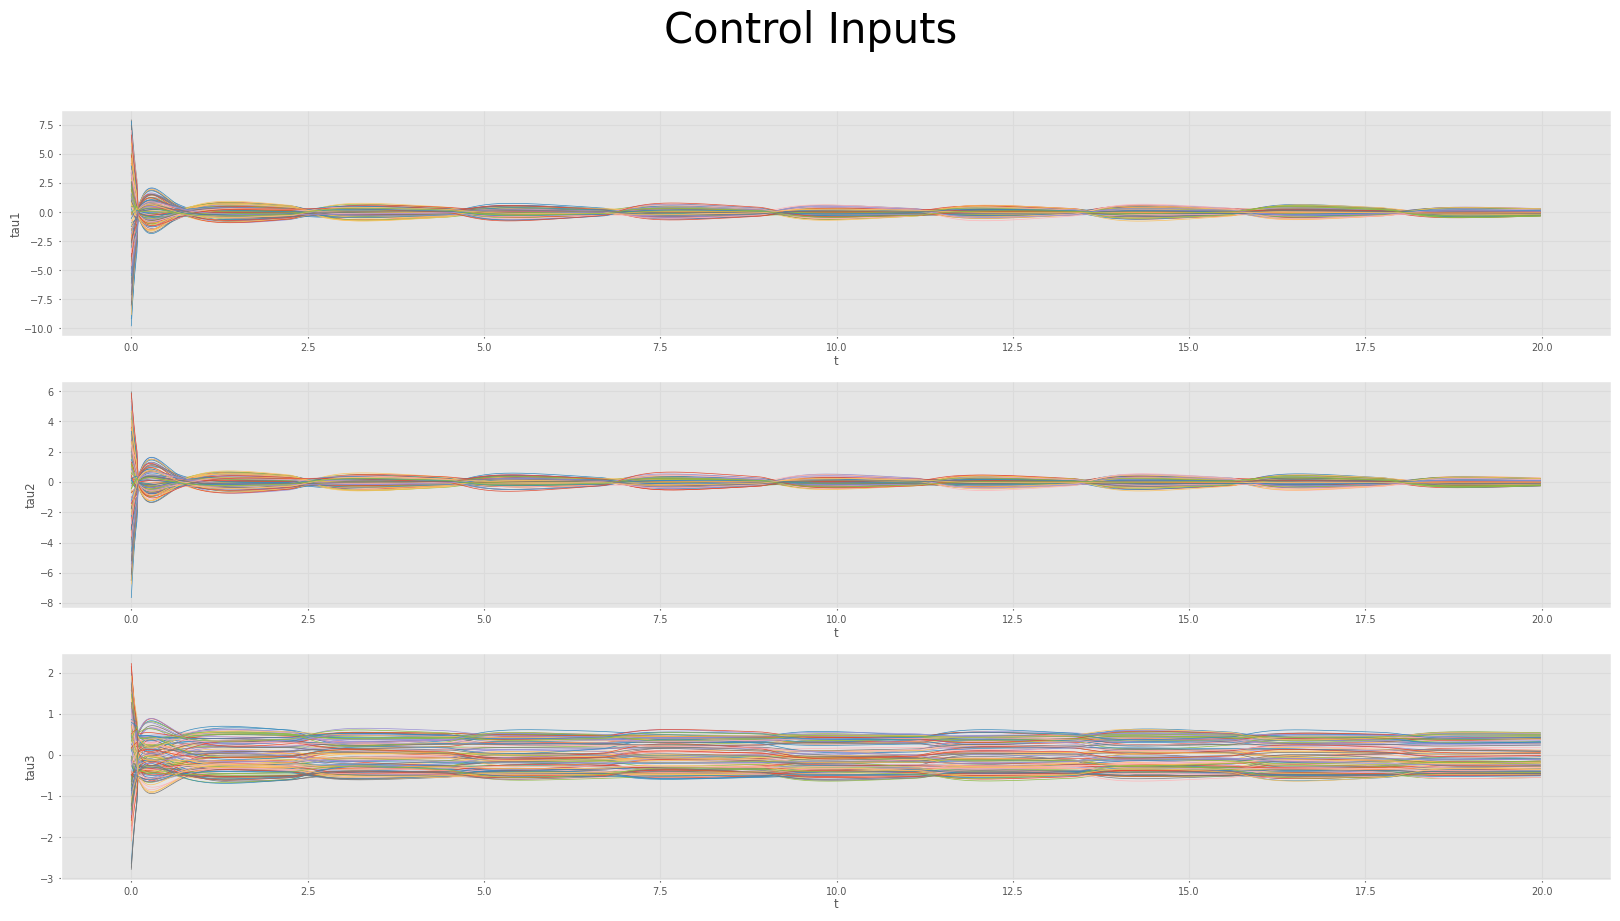

In [13]:
plt.figure(figsize = (20,10))
for j in range(num_traj):
    for i in range(int(num_joints)):
        plt.subplot(num_joints,1,i+1)
        plt.xlabel("t")
        plt.ylabel("tau"+str(i+1))
        plt.plot(T[:-1],U[j,:,i])
plt.suptitle("Control Inputs", fontsize=30)

Text(0.5, 0.98, 'Difference in Dynamics')

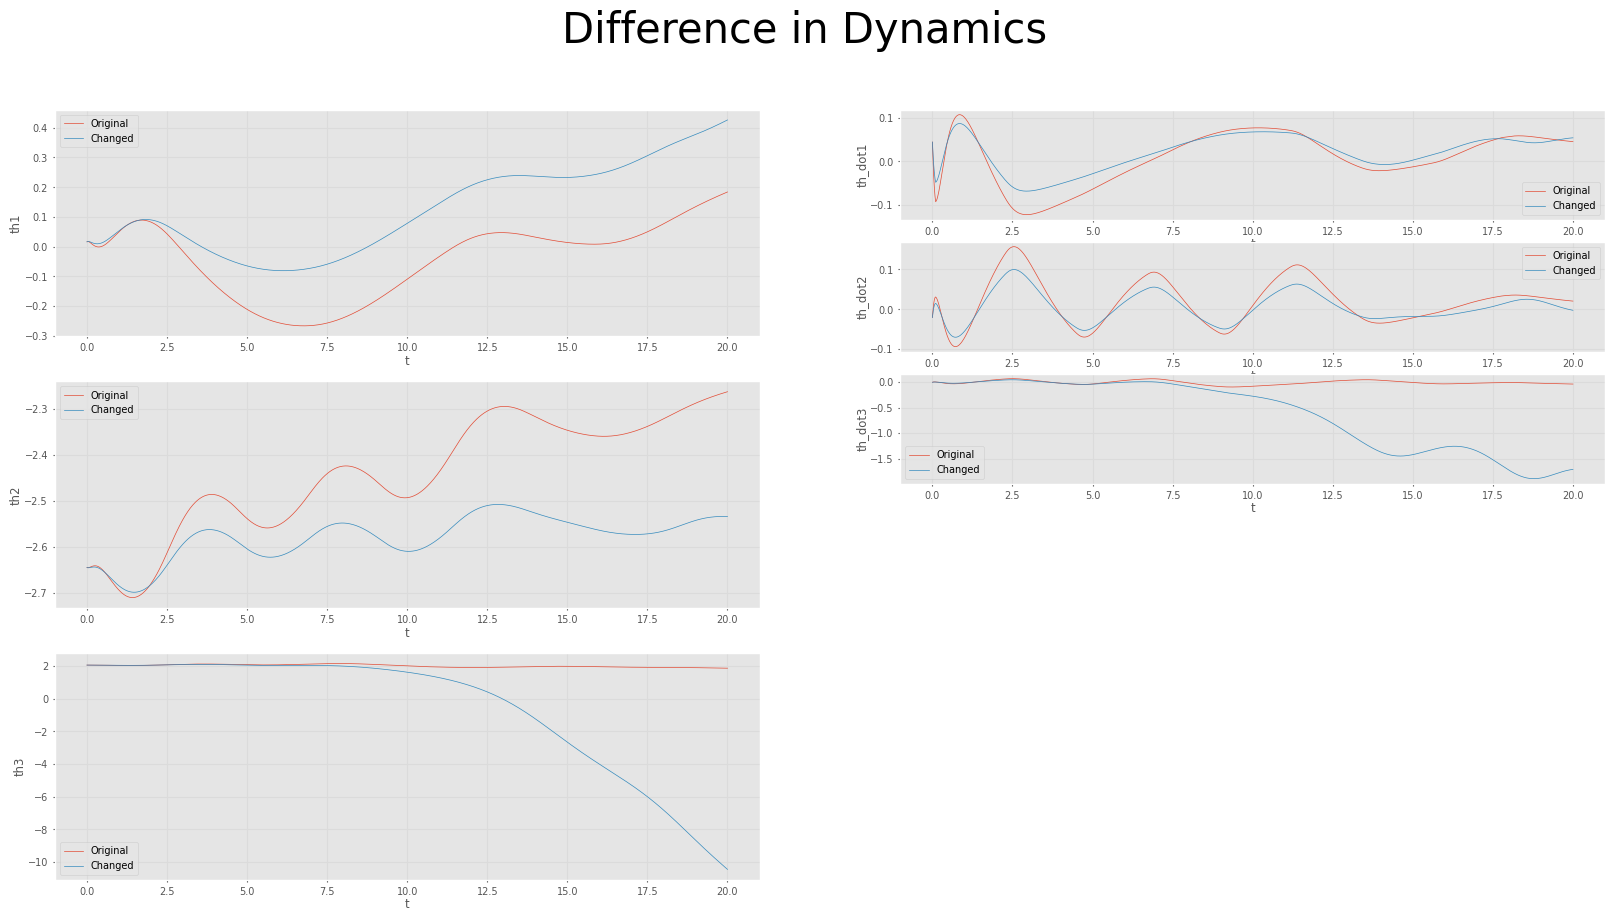

In [14]:
## difference in dynamics
plt.figure(figsize= (20,10))
j = random.randrange(0,num_traj)
for i in range(int(num_joints)):
    plt.subplot(num_joints,2,2*i+1)
    plt.xlabel("t")
    plt.ylabel("th"+str(i+1))
    plt.plot(T,X_unchanged[j,:,i], label = 'Original')
    plt.plot(T,X_changed[j,:,i], label = 'Changed')
    plt.legend()
    plt.subplot(num_states,2,2*i+2)
    plt.xlabel("t")
    plt.ylabel("th_dot"+str(i+1))
    plt.plot(T,X_unchanged[j,:,num_joints+i], label = "Original")
    plt.plot(T,X_changed[j,:,num_joints+i], label = "Changed")   
    plt.legend()
plt.suptitle("Difference in Dynamics", fontsize=30)

In [15]:
xs_train, us_train = X_unchanged[:num_train,:,:],U[:num_train,:,:]
xs_val, us_val = X_unchanged[num_train:,:,:],U[num_train:,:,:]

In [16]:
params = {}
params['alpha'] = 1;
params['beta'] = 0.04;
params['gamma'] = 1;
params['delta'] = 0.1

In [17]:
system_info ={}
system_info['dim_in'] = 2*num_states
system_info['dim_out'] = num_inputs
system_info['num_states'] = int(num_states/2)
system_info['num_inputs'] = num_inputs


In [18]:
bias = 0;
n = 100;
hyperpara_set = [0.756250, 0.756250, 0.843750, -3.125, 106.71875, bias];
eig_rho = hyperpara_set[0];
W_in_a = hyperpara_set[1];
alpha = hyperpara_set[2];
beta = 10**hyperpara_set[3];
k = round(hyperpara_set[4]/200*n);
kb = hyperpara_set[5];

In [19]:
W_in = W_in_a*(2*np.random.rand(n,system_info['dim_in'])-1);
res_net = sprandsym(n,k/n);
eig_D,_ = scipy.sparse.linalg.eigs(res_net,1);
eig_D = eig_D[0]
res_net = (eig_rho/(abs(eig_D)))*res_net;
res_net = res_net.toarray()

In [20]:
res_info = {}
res_info['W_in'] = W_in
res_info['res_net'] = res_net
res_info['alpha'] = alpha
res_info['beta'] = beta
res_info['kb'] = kb
res_info['n'] = n


In [21]:
data_info = {}
data_info['dt'] = dt
data_info['num_traj'] = num_traj
data_info['num_snaps'] = num_snaps-1
data_info['num_train'] = num_train
data_info['total_datapoints'] = num_traj*num_snaps


In [22]:
data_train = {}
data_train['x'] = xs_train
data_train['u'] = us_train
data_train['num_traj'] = num_train

data_val = {}
data_val['x'] = xs_val
data_val['u'] = us_val
data_val['num_traj'] = num_val

In [23]:
train = True
update_train_matricies = False
file_path = 'saved_models/reservior_comp/'+ robot_name + '/'

if train:
    Wout, r_end = train_reservior(data_train,data_info,res_info,system_info)

In [24]:
control_info = validate_reservoir(data_info, data_val, res_info, Wout, r_end, system_info)

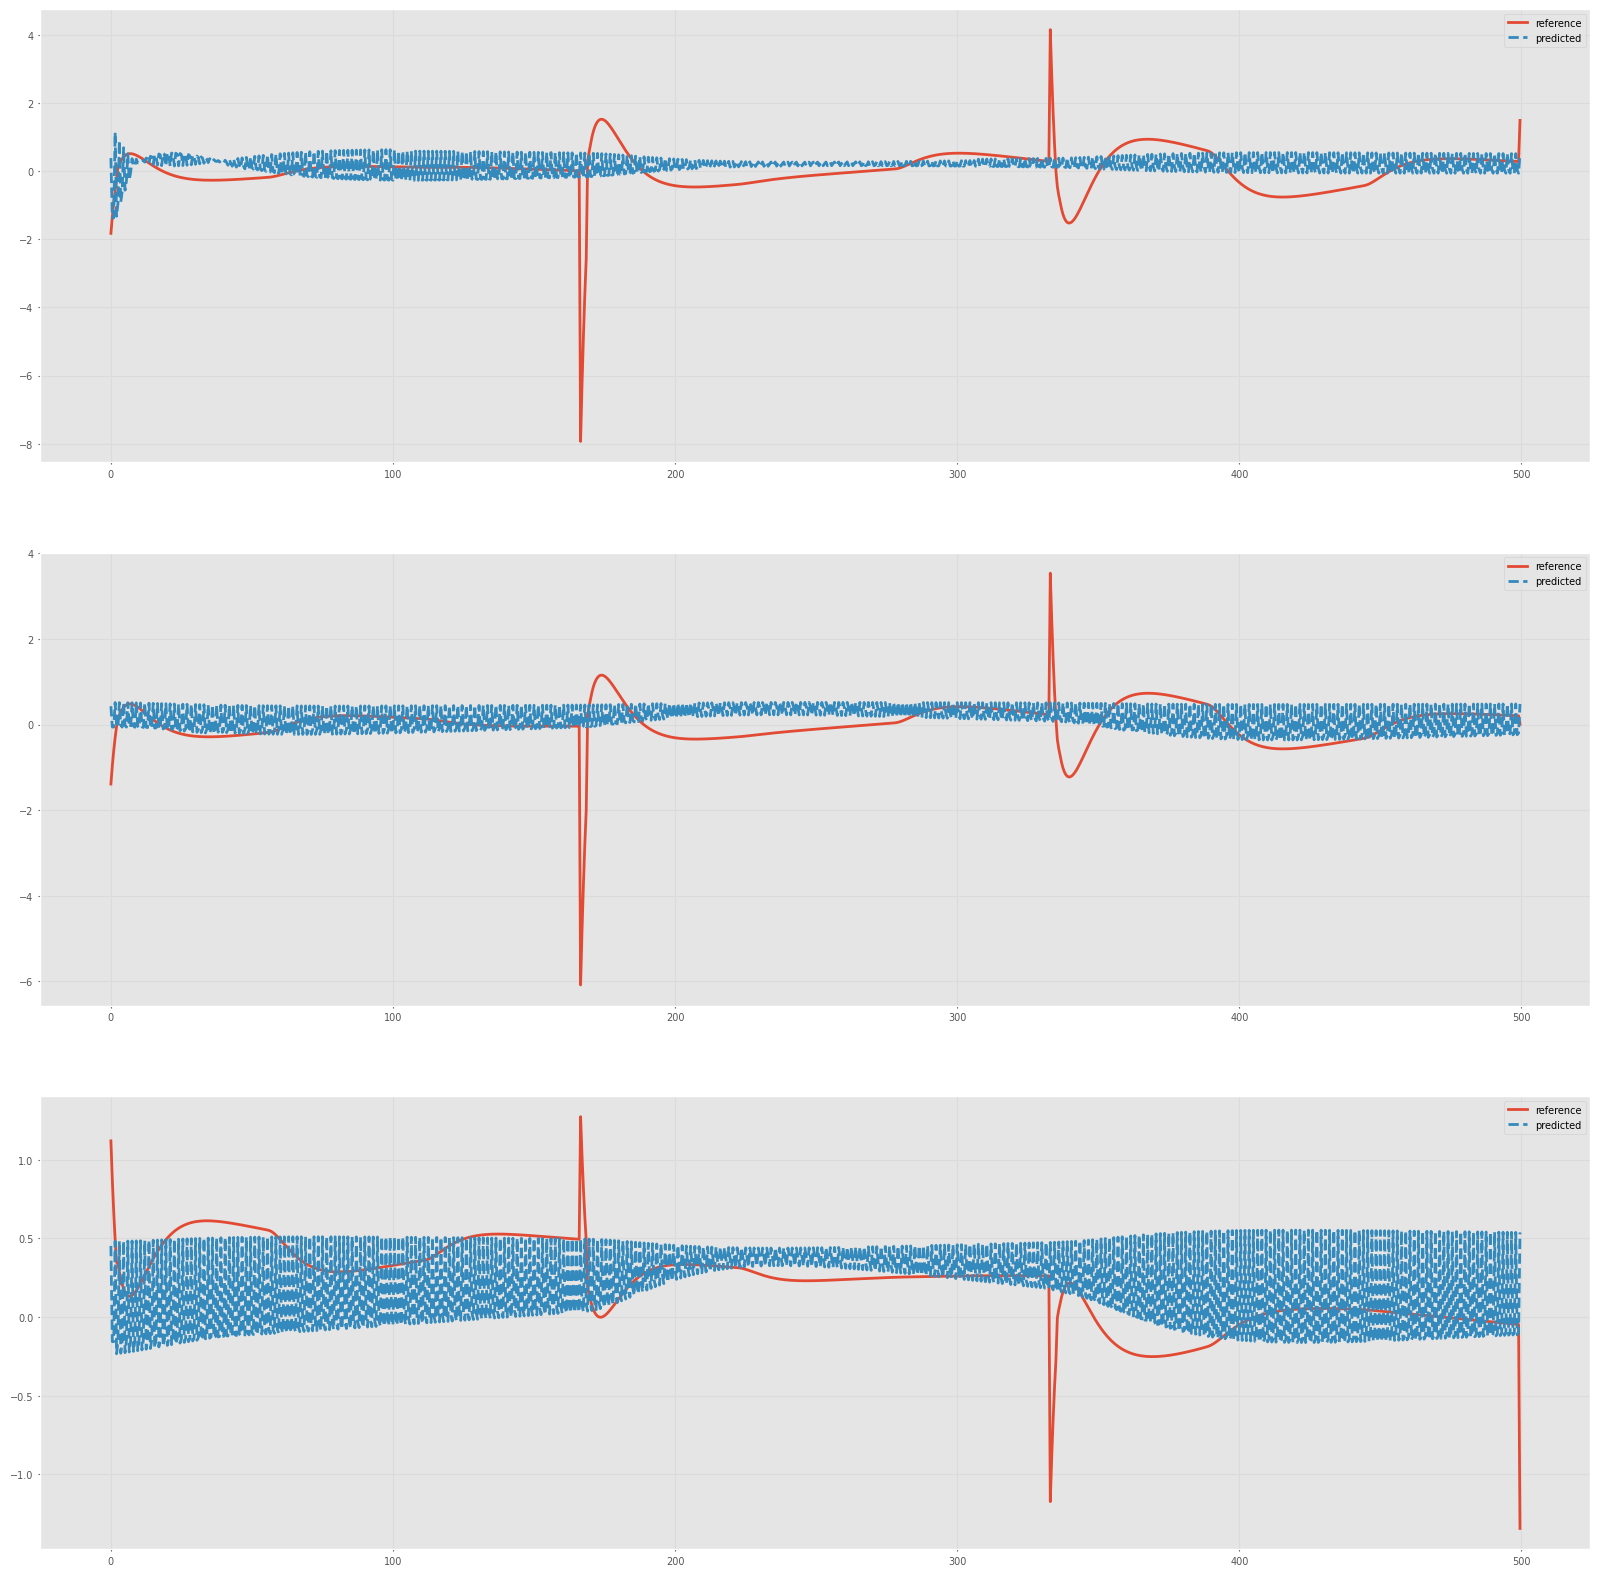

In [29]:

t_val = np.linspace(0,num_val*num_snaps*dt, num_snaps+1)
plt.figure(figsize=(20,20))
for i in range(num_inputs):
    plt.subplot(num_inputs,1,i+1)
    plt.plot(t_val[:-1],control_info['u_val_flat'][:num_snaps,i], label = 'reference', linewidth = 2.0)
    plt.plot(t_val[:-1],control_info['u_pred'][:num_snaps,i],'--', label = 'predicted', linewidth = 2.0)
    plt.legend()

In [ ]:
control_info['u_val_flat'].shape